# Simulation with laser noises

## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced laser noises and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

This type of noise addresses errors coming from the laser it self, encapsulating effects like the thermal motion arising a doppler effect on the laser frequency. Also, the laser amplitude profile yields an unequal exposure to the laser when using global pulses. It can also be subject to fluctuations from pulse to pulse. Hence we obtain these three laser noise models:

- Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.

- Waist of the laser : For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.

- Amplitude fluctuations: The `amp_sigma` parameter dictates fluctuations in the laser amplitude from pulse to pulse. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [3]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

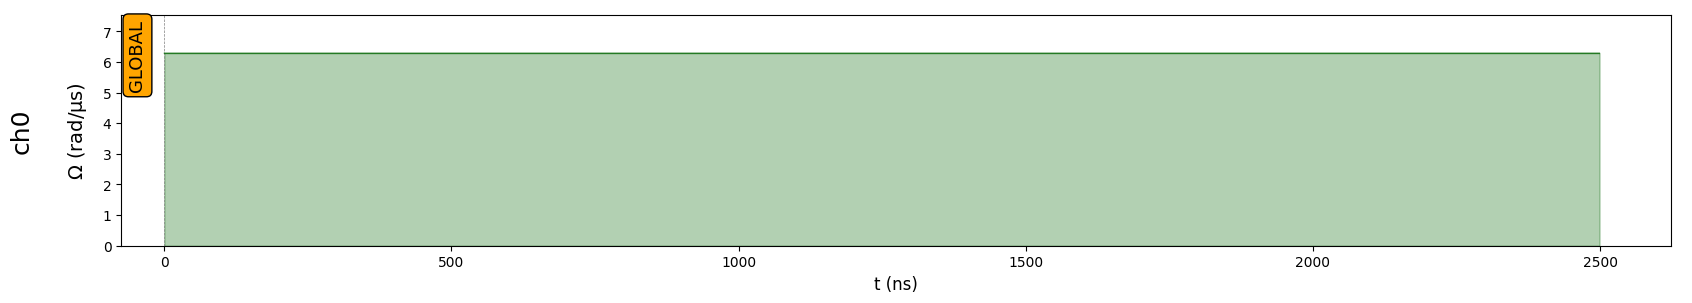

In [4]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now create the simulation object

In [6]:
sim = Simulation(seq, sampling_rate=0.05)
res_clean = sim.run()
obs = qutip.basis(2, 0).proj()
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

## Doppler Noise

As for any noise, Doppler noise is set via a `SimConfig` object. When averaging over several runs, it has the effect of damping the oscillations. Let's increase the number of runs in order to see this and get smoother curves.

Note that you may change the standard deviation of the doppler noise, which is $k \times \sqrt{k_B T / m}$, where $k$ is the norm of the effective wavevector of the lasers, by changing the temperature field, setting it in $\mu K$. We'll exaggerate the temperature field here to emphasize the effects of Doppler damping; the default value for temperature is 50$\mu K$.

In [7]:
config_doppler = SimConfig(
    noise="doppler", runs=100, temperature=5000, samples_per_run=10
)
sim.set_config(config_doppler)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       10
Noise types:           doppler
Temperature:           5000.0µK


Let us now simulate the entire sequence with Doppler noise, much like what we did in the SPAM case. We should see damped oscillations if the standard deviation is high enough. This is the case here, as we exaggerated the temperature field.

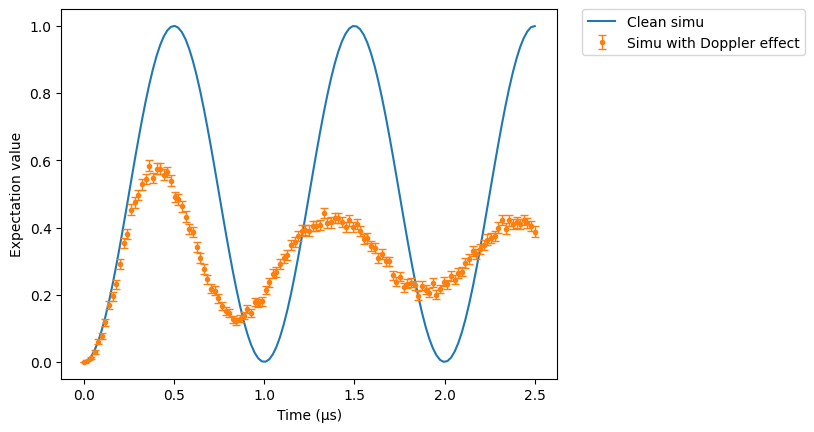

In [8]:
res_clean.plot(obs, label="Clean simu")
res_doppler = sim.run()
res_doppler.plot(obs, label="Simu with Doppler effect")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

## Amplitude noise

When activated, we switch to a description of the laser amplitude as a gaussian profile which standard deviation is `laser_waist`. 
The fluctuation is described with a Gaussian noise and `amp_sigma` it's standard deviation.

In [9]:
sim.reset_config()
config_amp_noise = SimConfig(
    noise="amplitude",
    runs=100,
)
sim.set_config(config_amp_noise)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       5
Noise types:           amplitude
Laser waist:           175.0μm
Amplitude standard dev.:  0.05


We observe that the apmlitude standard deviation, `amp_sigma`, is quite low. We imposed it to between 0 and 1.

You may ask why using 100 runs in this type of noise, 10 times the one we used for doppler noises. It's to have good average since the amplitude of pulses is multiplied by two gaussian funtions.

Let us now simulate the entire sequence with Amplitude noise, much like what we did in the SPAM case.

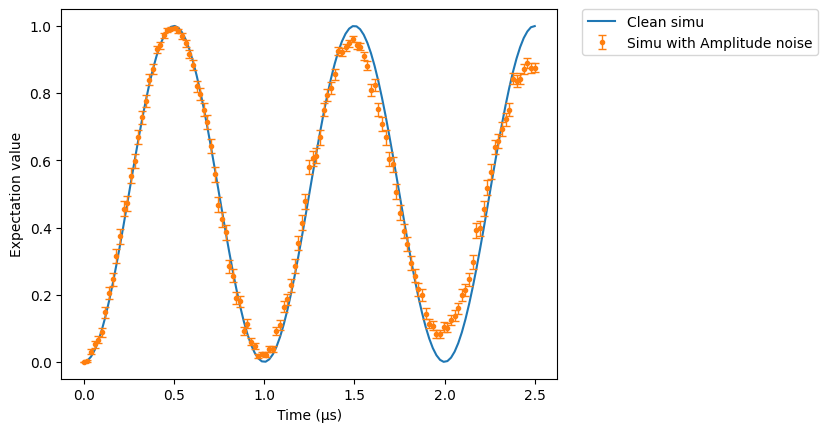

In [10]:
res_clean.plot(obs, label="Clean simu")
res_doppler = sim.run()
res_doppler.plot(obs, label="Simu with Amplitude noise")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

Let's increase the `laser_waist` to $200 \mu m$ and `amp_sigma` to $0.1$

In [11]:
sim.reset_config()
config_amp_noise = SimConfig(
    noise="amplitude", runs=100, laser_waist=200, amp_sigma=0.1
)
sim.set_config(config_amp_noise)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       5
Noise types:           amplitude
Laser waist:           200μm
Amplitude standard dev.:  0.1


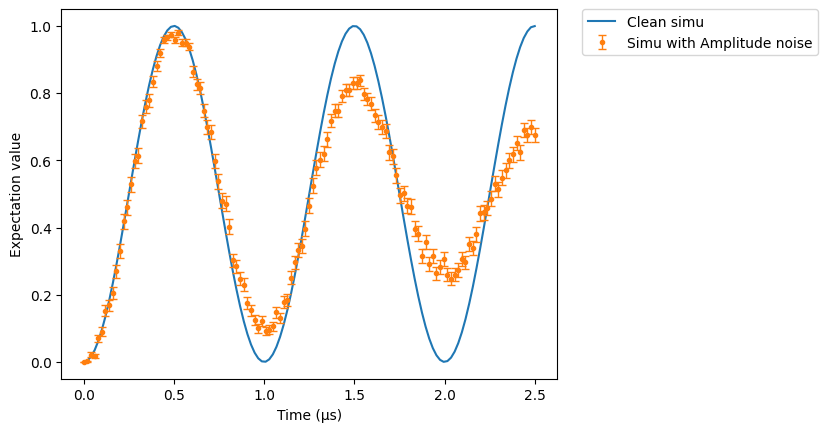

In [12]:
res_clean.plot(obs, label="Clean simu")
res_doppler = sim.run()
res_doppler.plot(obs, label="Simu with Amplitude noise")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

We observe an exponential damping of the amplitude, but slower than the one due to the doppler effect.

## Multiple Atoms

We will now run the AFM preparation sequence from the Pulser tutorial with our noise models, and compare the results to the clean case.

At this stage, you know how to manipulate SPAM errors, and laser noises. In this multi qubtits case, we will sum up all these effects.

In [14]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.rectangle(N_side, N_side, R_interatomic, prefix="q")

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

In [15]:
config_all_noise = SimConfig(
    noise=("SPAM", "doppler", "amplitude"), runs=100, samples_per_run=10
)
simul = Simulation(
    seq, sampling_rate=0.05, evaluation_times=0.2, config=config_all_noise
)
spam_results = simul.run()
simul.reset_config()
clean_results = simul.run()

We now plot the simulation results by sampling the final states.

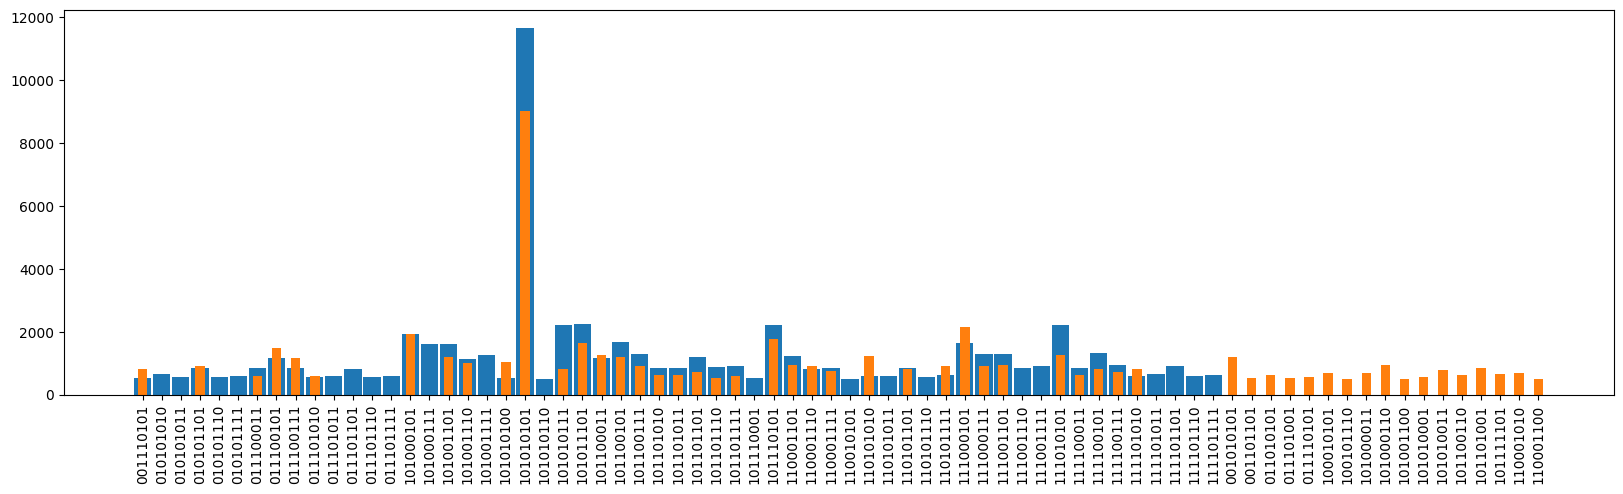

In [16]:
plt.figure(figsize=(20, 5))
spam_count = spam_results.sample_final_state(N_samples=1e5)
clean_count = clean_results.sample_final_state(N_samples=1e5)

clean_most_freq = {k: v for k, v in clean_count.items() if v > 500}
spam_most_freq = {k: v for k, v in spam_count.items() if v > 500}

plt.bar(
    list(clean_most_freq.keys()), list(clean_most_freq.values()), width=0.9
)
plt.bar(list(spam_most_freq.keys()), list(spam_most_freq.values()), width=0.5)

plt.xticks(rotation="vertical")
plt.show()

The bars represent the simulation results as populations of bitstrings. They're colored blue for the noiseless simulation, and orange for the noisy one. We clearly identify the antiferromagnetic state as the most populated one in both cases, but it is slightly less populated in the noisy case, while some other bitstrings, not present in the noiseless case, appear.